# Bandes électroniques du cristal de $Sr_2NCl$

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors

import plotly.graph_objects as go
import itertools
from scipy.constants import hbar

In [13]:
mp_key ="iX81lxwugQ7QfGznstwLyMrndo3WUZbE"
mp_id = "mp-23033"

with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)
conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

## 1. Zone de Brillouin 

Afin de visualiser les bandes électroniques dans un graphe 2d, nous allons les analyser sur plusieurs segments de la zone de brillouin.

In [20]:
plot_brillouin_zone(el_bs.structure)

c:\Users\roeke\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymatgen\symmetry\bandstructure.py:181: UserWarning:

The input structure does not match the expected standard primitive! The path may be incorrect. Use at your own risk.



## 2. Bandes interdite et densité électronique

Dans les matériaux non-métaux, il y a un écart entre l'énergie de la bande de valence et de la bande de conduction où la densité électronique est nul. La grandeur de cet écart nous donne une indication sur le type de matériaux : isolant ou semiconducteur.

In [15]:
fig_el_bs_and_dos = get_plot_bs_and_dos(el_bs, el_dos, plot_range=[-4,4])
xvals = fig_el_bs_and_dos.to_dict()["data"][0]["x"]

yvals_vbm = fig_el_bs_and_dos.to_dict()["data"][4]["y"]
yvals_cbm = fig_el_bs_and_dos.to_dict()["data"][5]["y"]

xvals_band_edges = []
yvals_band_edges = []
for i in el_bs.get_vbm()["kpoint_index"]:
    xvals_band_edges.append(xvals[i])
    yvals_band_edges.append(yvals_vbm[i])
for i in el_bs.get_cbm()["kpoint_index"]:
    xvals_band_edges.append(xvals[i])
    yvals_band_edges.append(yvals_cbm[i])

for i in el_bs.get_vbm()["kpoint_index"]:
    scatter = go.Scatter(
        x = xvals_band_edges, y = yvals_band_edges,
        mode = "markers", marker = dict(color="black"),
        showlegend=False)
    fig_el_bs_and_dos.add_trace(scatter)
fig_el_bs_and_dos.update_layout(xaxis_range = [xvals[0], xvals[-1]])
fig_el_bs_and_dos.show()

In [16]:
gap = el_bs.get_band_gap()

data = [['bande directe',"oui" if(gap.get('direct')) else "non"],
        ['E_g',str(gap.get('energy')) + "[eV]"],
        ['transition',gap.get('transition')]
        ]

for row in data:
    print("{:<16} {:<10}".format(row[0], row[1]))   

bande directe    oui       
E_g              1.9398000000000004[eV]
transition       F-F       


### Commentaire
Les isolant électrique sont caractérisé par $E_g\sim 5-10 [eV]$ alors que pour les semiconducteurs, on a : $E_g< 1 [eV]$. On se trouve dans un cas intermédaire avec un band gap de $2[eV]$

## 4. Dispersion

La relation de dispersion décrit la variation de l'énergie des électrons avec le vecteur d'onde. Nous allons calculer $ \frac{\Delta E}{\Delta K} $ afin de la quantifier.

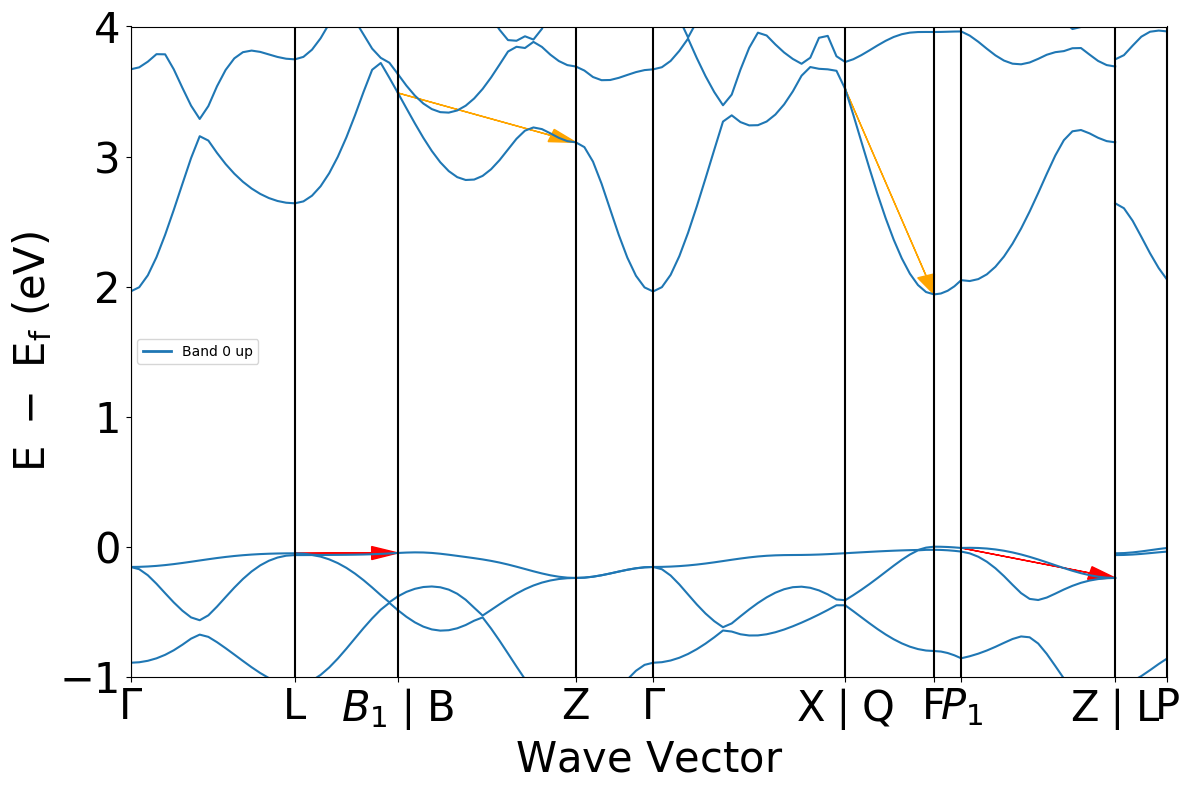

In [21]:
#1. get data
bsp = BSPlotter(el_bs)
data = bsp.bs_plot_data()
energies = data.get('energy')
distances = np.array(data.get('ticks').get('distance'))
distances, indices = np.unique(np.array(distances), return_index=True)
id_Val = 16-1
id_Cond = 17-1


length = len(distances) - 1
slope = np.zeros((2, 2))
Val_Indices = np.zeros((2, 2))
Cond_Indices = np.zeros((2, 2))

#2. loop over all the segments
for i in range(length):
    # Slope computation
    dk = distances[i + 1] - distances[i]
    dE_val = energies.get('1')[i][id_Val][-1] - energies.get('1')[i][id_Val][0]
    dE_cond = energies.get('1')[i][id_Cond][-1] - energies.get('1')[i][id_Cond][0]
    dEvdk = np.abs(dE_val / dk)
    dEcdk = np.abs(dE_cond / dk)

    # Max and min slope for valence band
    if i == 0 or dEvdk < slope[0][0]:
        slope[0][0] = dEvdk
        Val_Indices[0] = [i, i + 1]
    elif dEvdk > slope[0][1]:
        slope[0][1] = dEvdk
        Val_Indices[1] = [i, i + 1]

    # Max and min slope for conduction band
    if i == 0 or dEcdk < slope[1][0]:
        slope[1][0] = dEcdk
        Cond_Indices[0] = [i, i + 1]
    elif dEcdk > slope[1][1]:
        slope[1][1] = dEcdk
        Cond_Indices[1] = [i, i + 1]

# 3. fill matrices k and e
kv = np.zeros((2, 2)) ; kc = np.zeros((2, 2))
ev = np.zeros((2, 2)) ; ec = np.zeros((2, 2))

for i in range(2):
    for j in range(2):
        kv[i][j] = distances[int(Val_Indices[i][j])]
        kc[i][j] = distances[int(Cond_Indices[i][j])]
        ev[i][j] = energies.get('1')[int(Val_Indices[i][0])][id_Val][0 if j == 0 else -1]
        ec[i][j] = energies.get('1')[int(Cond_Indices[i][0])][id_Cond][0 if j == 0 else -1]

bsp.get_plot(ylim=(-1, 4))
for i in range(2):
    plt.arrow(
        kv[i][0],ev[i][0],kv[i][1] - kv[i][0],ev[i][1] - ev[i][0],
        color="red",head_width=0.1,length_includes_head=True,
    )
    plt.arrow(
        kc[i][0],ec[i][0],kc[i][1] - kc[i][0],ec[i][1] - ec[i][0],
        color="orange",head_width=0.1,length_includes_head=True,
        )

## 5. Masse éffective

La masse effective est un outil mathématique qui consiste à considérer une masse variable des électrons selon leur état (énergie et vecteur d'onde).En toute généralité elle est décrit par un tenseur : 

$$\frac {1}{m}_{i,j} = \frac{1}{\bar{h}^2}\frac{\partial E}{\partial k_i\partial k_j}$$

Qu'on simplifier en supposant une dispersion parabolique :

$$m = \frac{k^2 \bar{h}^2}{2E}$$


In [ ]:
eV = 1.602e-19
A = 1e-10
vbm = el_bs.get_vbm()
cbm = el_bs.get_cbm()
#Valeurs k et énergie
valence_k = vbm['kpoint'].frac_coords
conduction_k = cbm['kpoint'].frac_coords

val_energy = vbm['energy']
cond_energy = cbm['energy']

val_masse = (hbar**2*(valence_k[0]**2+valence_k[1]**2+valence_k[2]**2))/(2*abs(val_energy)*eV*A)
cond_masse = (hbar**2*(conduction_k[0]**2+conduction_k[1]**2+conduction_k[2]**2))/(2*abs(cond_energy)*eV*A)

print("la masse effective : ")
print("au sommet de la bande de valence : ", val_masse, "kg")
print("à la base de la bande de conduction : ", cond_masse, "kg")

la masse effective : 
au sommet de la bande de valence 6.417159490814416e-41 kg
à la base de la bande de conduction 3.7368834577670665e-41 kg
